https://archive.ics.uci.edu/dataset/14/breast+cancer

### Imports

In [35]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [36]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by=['fpr','tpr']).reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [37]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    elif dataset == "breast_cancer":
        from ucimlrepo import fetch_ucirepo
        from sklearn.compose import ColumnTransformer
        from sklearn.pipeline import Pipeline
        from sklearn.impute import SimpleImputer
        from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
        from sklearn.model_selection import train_test_split

        # Fetch and print columns for the dataset your code is using

        # 1. Fetch data for Breast Cancer (ID 15)
        bc = fetch_ucirepo(id=14)
        X_df, y_df = bc.data.features, bc.data.targets

        # 2. Replace '?' with a standard missing value format
        X_df = X_df.replace('?', np.nan)

        # 3. Encode the target variable
        y = LabelEncoder().fit_transform(y_df.to_numpy().ravel())

        # 4. Define column lists using the correct names for this dataset
        categorical_features = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'breast', 'breast-quad', 'irradiat']
        numeric_features = ['deg-malig']

        # 5. Create preprocessing pipelines
        numeric_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        categorical_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # 6. Build the master preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_pipeline, numeric_features),
                ('cat', categorical_pipeline, categorical_features)
            ])

        # 7. Apply the transformations
        X_sparse = preprocessor.fit_transform(X_df)

        X = X_sparse.toarray()

        # --- CRITICAL DEBUGGING STEP ---
        print(f"Shape of X after preprocessing: {X.shape}")
        # This MUST print a shape like (286, 46). If it prints (286, 0), the preprocessor failed.
        # -----------------------------

        # 8. Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.7, random_state=42, stratify=y
        )

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

        y_train = y_train.reshape(-1, 1) if len(y_train.shape) == 1 else y_train
        y_test = y_test.reshape(-1, 1) if len(y_test.shape) == 1 else y_test


        # 9. Concatenate the data
        train_data = np.concatenate((X_train, y_train), axis=1)
        test_data = np.concatenate((X_test, y_test), axis=1)
        val_data = test_data  # For simplicity, using test data as validation data

        print(f"Shape of training data: {train_data.shape}")
        print(f"Shape of test data: {test_data.shape}")

        print("\nData successfully processed and concatenated.")
        print(f"Shape of final training data: {train_data.shape}")


    return train_data, test_data, val_data


## Calculate Statistics function

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





In [40]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

## Data1: Logistic regression

In [41]:
from sklearn.model_selection import StratifiedKFold
import torch
import torch.utils.data as data

train_data, test_data, val_data = generate_data("breast_cancer")  # Change to "data1", "data2", or "pneumoniaMNIST" as needed


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)





Shape of X after preprocessing: (286, 39)
Training data shape: (200, 39), (200,)
Test data shape: (86, 39), (86,)
Shape of training data: (200, 40)
Shape of test data: (86, 40)

Data successfully processed and concatenated.
Shape of final training data: (200, 40)


### Undersampling

In [42]:
import numpy as np
from collections import Counter

# --- This block generates the list of ratios for your experiment ---
def generate_ratios(train_data):
    # 1. Get original class counts from your train_dataset

    try:
        original_labels = np.array(train_data.targets).flatten()
    except AttributeError:
        original_labels = train_data[:, -1]

    original_counts = Counter(original_labels)
    num_pos_original = original_counts.get(1, 0)  
    num_neg_original = original_counts.get(0, 0)  
    print(f"Original class counts: {num_pos_original} positives, {num_neg_original} negatives")

    # The pivot point for your function's logic
    orig_sample_ratio = num_pos_original / num_neg_original 

    # 2. Define how many steps for each regime
    N_POINTS_PER_REGIME = 50  # You can change this

    # 3. Generate ratios for Regime 1 (from near 0 up to the pivot)
    # This will test scenarios from extreme negative-class dominance up to the original balance.
    print(f"Generating ratios for Regime 1 (target ratio < {orig_sample_ratio})...")
    ratios_regime1 = np.geomspace(
        start=1/num_neg_original,                      # A small starting ratio (e.g., 1 positive for every 10 negatives)
        stop=orig_sample_ratio,         # Go up to the original ratio
        num=N_POINTS_PER_REGIME,
        endpoint=False                  # Exclude the pivot itself to avoid the 'else' block
    )

    # 4. Generate ratios for Regime 2 (from the pivot up to 3494)
    # This will test scenarios from the original balance up to extreme positive-class dominance.
    print(f"Generating ratios for Regime 2 (target ratio > {orig_sample_ratio})...")
    ratios_regime2 = np.geomspace(
        start=orig_sample_ratio, # Start just above the pivot
        stop=num_pos_original,                      # Your specified upper limit
        num=N_POINTS_PER_REGIME
    )

    # 5. Combine, sort, and create the final list for the loop
    #    We also add the original ratio to ensure we have a baseline run.
    all_ratios = sorted(list(np.concatenate([ratios_regime1, ratios_regime2, [orig_sample_ratio]])))

    print(f"\nGenerated {len(all_ratios)} unique sample ratios to test.")
    print("First few ratios:", np.round(all_ratios[:5], 3))
    print("Last few ratios:", np.round(all_ratios[-5:], 2))

    return all_ratios

In [43]:
import numpy as np
def undersample_dataset(train_dataset, sample_ratio):

    
    
    # Get the labels from the dataset (0 for normal, 1 for pneumonia)
    try:
        labels = np.array(train_dataset.targets).flatten()
    except AttributeError:
        labels = train_dataset[:, -1]

    # Find the indices for the positive (pneumonia) and negative (normal) classes
    positive_indices = np.where(labels == 1)[0]
    negative_indices = np.where(labels == 0)[0]
    num_orig_positive = len(positive_indices)
    num_orig_negative = len(negative_indices)

    orig_sample_ratio = num_orig_positive / num_orig_negative
    print(f"Original sample ratio (positive:negative): {orig_sample_ratio:.2f}")

    #based on sample ratio find the number of positive or negative samples
    if sample_ratio>orig_sample_ratio:
        neg_samples = int(num_orig_positive / sample_ratio)
        pos_samples = num_orig_positive
        sampled_negative_indices = np.random.choice(negative_indices, neg_samples, replace=False)
        final_indices = np.concatenate([sampled_negative_indices, positive_indices])
    elif sample_ratio<orig_sample_ratio:
        pos_samples = int(sample_ratio * num_orig_negative)
        neg_samples = num_orig_negative
        sampled_positive_indices = np.random.choice(positive_indices, pos_samples, replace=False)
        final_indices = np.concatenate([sampled_positive_indices, negative_indices])
    else:
        pos_samples = num_orig_positive
        neg_samples = num_orig_negative
        final_indices = np.concatenate([positive_indices, negative_indices])
        
    # Shuffle the final indices to mix positive and negative samples
    np.random.shuffle(final_indices)

    # Create a subset of the original dataset with the sampled indices
    return train_dataset[final_indices]

### Regular training

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
# Logistic Regression
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
clf = LogisticRegression(fit_intercept=True)
clf.fit(X_train, y_train)

#calculate ROC results
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
results_original_roc = {"fpr": fpr_roc, "tpr": tpr_roc, "thresholds": threshold_roc, "name": "Logistic Regression", "auc": auc(fpr_roc, tpr_roc), "model": clf}

## Undersampling ROC curve

In [45]:


#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds 
list_folds_best_models = []  # List to store best models from all folds

list_weighted_clfs = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data[:, :-1], train_data[:, -1])):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage

    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")
    X_train_fold = train_data[train_ids][:, :-1]
    y_train_fold = train_data[train_ids][:, -1]
    X_test_fold = train_data[val_ids][:, :-1]
    y_test_fold = train_data[val_ids][:, -1]
    all_ratios = generate_ratios(np.c_[X_train_fold, y_train_fold])  # Combine features and labels for ratio generation
    for i, sample_ratio in enumerate(all_ratios):
        print("="*60)
        print(f"--- STARTING STAGE {i+1} FOR SAMPLE RATIO: {sample_ratio} ---")
        print("="*60)

        undersampled_train_dataset = undersample_dataset(np.c_[X_train_fold, y_train_fold], sample_ratio)
        X_train_resampled = undersampled_train_dataset[:, :-1]  # All columns except the last one
        y_train_resampled = undersampled_train_dataset[:, -1]   # Last column is the target

        clf_weighted = LogisticRegression(fit_intercept=True)
        clf_weighted.fit(X_train_resampled, y_train_resampled)

        res = get_fpr_tpr(clf_weighted, X_test_fold, y_test_fold, threshold=0.5)

        array_of_all_fprs, array_of_all_tprs, threshold_vals = roc_curve(y_test_fold, clf_weighted.predict_proba(X_test_fold)[:, 1])

        current_result = {
            "model": clf_weighted,
            "fpr": res["fpr"],
            "tpr": res["tpr"],
            "threshold": 0.5,
            "full_roc": {"fpr": array_of_all_fprs, "tpr": array_of_all_tprs, "thresholds": threshold_vals},
        }
        list_weighted_clfs.append(current_result)
    best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)

--- Starting Fold 1/4 ---
Original class counts: 45 positives, 105 negatives
Generating ratios for Regime 1 (target ratio < 0.42857142857142855)...
Generating ratios for Regime 2 (target ratio > 0.42857142857142855)...

Generated 101 unique sample ratios to test.
First few ratios: [0.01  0.01  0.011 0.012 0.013]
Last few ratios: [30.78 33.84 37.21 40.92 45.  ]
--- STARTING STAGE 1 FOR SAMPLE RATIO: 0.009523809523809525 ---
Original sample ratio (positive:negative): 0.43
--- STARTING STAGE 2 FOR SAMPLE RATIO: 0.010277203383606973 ---
Original sample ratio (positive:negative): 0.43
--- STARTING STAGE 3 FOR SAMPLE RATIO: 0.011090195485742362 ---
Original sample ratio (positive:negative): 0.43
--- STARTING STAGE 4 FOR SAMPLE RATIO: 0.011967500429948081 ---
Original sample ratio (positive:negative): 0.43
--- STARTING STAGE 5 FOR SAMPLE RATIO: 0.012914205770757919 ---
Original sample ratio (positive:negative): 0.43
--- STARTING STAGE 6 FOR SAMPLE RATIO: 0.01393580152060214 ---
Original sampl

In [46]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/Logistic_breast_cancer_undersampling.pkl')




Data saved to pickle/Logistic_breast_cancer_undersampling.pkl


{'best_models': [[{'model': LogisticRegression(),
    'fpr': np.float64(0.0),
    'tpr': np.float64(0.21428571428571427),
    'threshold': np.float64(0.05816122418176974)},
   {'model': LogisticRegression(),
    'fpr': np.float64(0.027777777777777776),
    'tpr': np.float64(0.35714285714285715),
    'threshold': np.float64(0.0460789645546135)},
   {'model': LogisticRegression(),
    'fpr': np.float64(0.05555555555555555),
    'tpr': np.float64(0.42857142857142855),
    'threshold': np.float64(0.03216388685916777)},
   {'model': LogisticRegression(),
    'fpr': np.float64(0.1111111111111111),
    'tpr': np.float64(0.5),
    'threshold': np.float64(0.9445188272914538)},
   {'model': LogisticRegression(),
    'fpr': np.float64(0.1388888888888889),
    'tpr': np.float64(0.6428571428571429),
    'threshold': np.float64(0.75958147852421)},
   {'model': LogisticRegression(),
    'fpr': np.float64(0.2222222222222222),
    'tpr': np.float64(0.7142857142857143),
    'threshold': np.float64(0.689

# Load pickle

In [47]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/Logistic_breast_cancer_undersampling.pkl')

Data loaded successfully.


### Ensemble prediction using voting

In [48]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 39 models across all folds.
Extracting full dataset...
Getting predictions from all models...


## Load NP curve pickle

In [49]:
from predict_ensemble_and_evaluate import load_from_pickle_constrained_roc

# Load the constrained ROC curve results
constrained_points = load_from_pickle_constrained_roc(filename='pickle/Logistic_Breast_Cancer_NP_roc_curve.pkl')

Constrained ROC curve points loaded from pickle/Logistic_Breast_Cancer_NP_roc_curve.pkl



--- Plotting all ROC curves for comparison ---


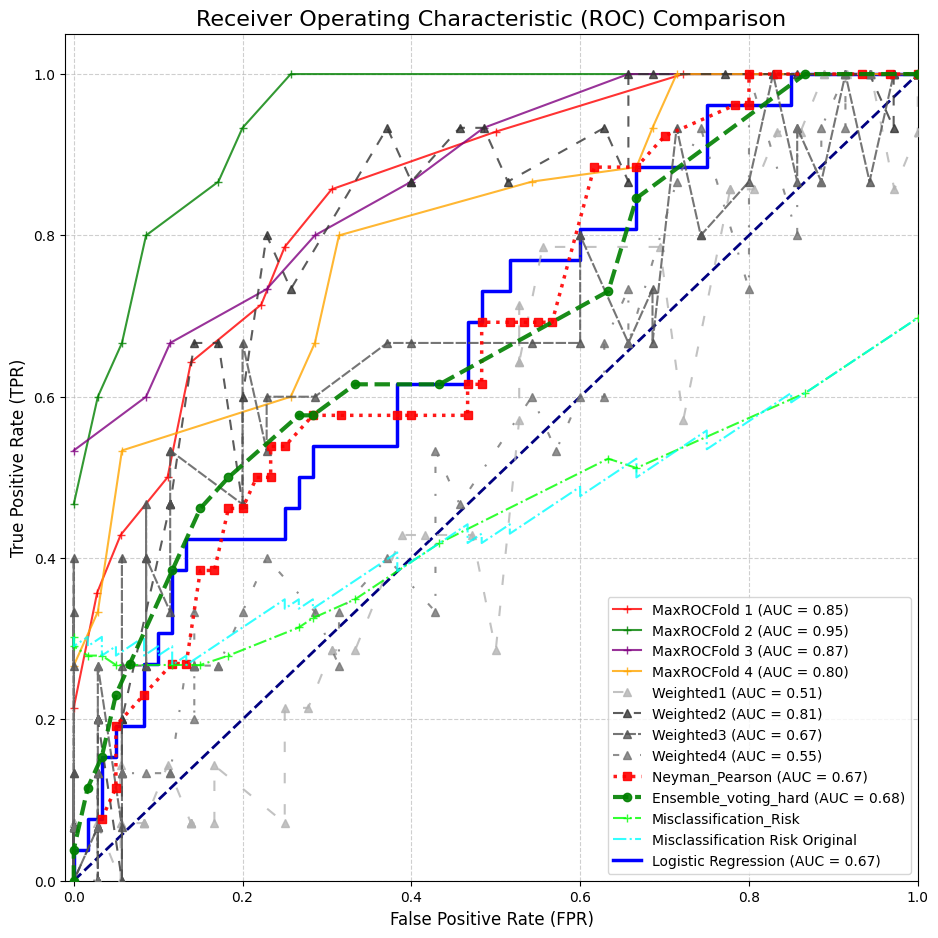

In [50]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(misclassification_risk)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    results_original_roc=results_original_roc, plot_name="logistic_undersampling_BreastCancer", prior_prob=prior_proba
)